In [44]:
from enum import unique

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans          
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder,StandardScaler
# from  sklearn.feature_extraction.text import CountVectorizer
# from sklearn import metrics
# from xgboost import XGBRegressor
# from datetime import datetime



import warnings

from fontTools.subset import subset

warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv('Customer_Segmentation.csv')
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Finding missing values

In [46]:
counts_missing = df.isnull().sum()
missing_percentage = (counts_missing / len(df)) * 100

#summary of missing values
missing_summary = pd.DataFrame({
    'Missing Values': counts_missing,
    'Percentage': missing_percentage
}).reset_index().rename(columns={'index': 'Column'})
print(missing_summary)

                 Column  Missing Values  Percentage
0                    ID               0    0.000000
1            Year_Birth               0    0.000000
2             Education               0    0.000000
3        Marital_Status               0    0.000000
4                Income              24    1.071429
5               Kidhome               0    0.000000
6              Teenhome               0    0.000000
7           Dt_Customer               0    0.000000
8               Recency               0    0.000000
9              MntWines               0    0.000000
10            MntFruits               0    0.000000
11      MntMeatProducts               0    0.000000
12      MntFishProducts               0    0.000000
13     MntSweetProducts               0    0.000000
14         MntGoldProds               0    0.000000
15    NumDealsPurchases               0    0.000000
16      NumWebPurchases               0    0.000000
17  NumCatalogPurchases               0    0.000000
18    NumSto

# Filling missing data
## Income
we have 24 missing values in the Income column, which is significant. We will handle this by using median imputation.

1. Median is robust to outliers, which is important for income data that may have extreme values.
2. It preserves the distribution of the data better than mean imputation.

In [47]:
#we decided to use median impoutation for the missing values in Income column.This is because of the following reasons

df['Income'].fillna(df['Income'].median(), inplace=True)
print(df["Income"].isnull().sum()) 


0


## Finding duplicates
No duplicates found

In [48]:
df.duplicated().sum()

0

## Date Formatting
Dt_Customer is in the format of 'dd-mm-yyyy', we will convert it to a datetime object for easier analysis.

In [49]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')
print("First 20 enrollment dates:")
print(df['Dt_Customer'].head(20))

print('\nNull vales after formatting: ')
print(df[df['Dt_Customer'].isnull()])

First 20 enrollment dates:
0    2012-09-04
1    2014-03-08
2    2013-08-21
3    2014-02-10
4    2014-01-19
5    2013-09-09
6    2012-11-13
7    2013-05-08
8    2013-06-06
9    2014-03-13
10   2013-11-15
11   2012-11-13
12   2013-11-15
13   2013-11-15
14   2012-10-10
15   2012-11-24
16   2012-12-24
17   2012-08-31
18   2013-03-28
19   2012-11-03
Name: Dt_Customer, dtype: datetime64[ns]

Null vales after formatting: 
Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response]
Index: []

[0 rows x 29 columns]


## Checking for constant columns
Constant columns are those that have the same value for all rows. These columns do not provide any useful information for analysis or modeling, so they can be safely removed.

In [50]:

constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print(constant_columns)


['Z_CostContact', 'Z_Revenue']


## Dropping constant

### found 2
- AcceptedCmp3
- Z_Revenue

We found 2 constant columns: 'AcceptedCmp3' and 'Z_Revenue'. These columns have the same value for all rows, which means they do not provide any useful information for analysis or modeling. Therefore, we will drop them from the dataset.

In [51]:

# Remove constant columns
df = df.drop(columns=constant_columns)

print(f"Removed {len(constant_columns)} constant columns: {constant_columns}")

Removed 2 constant columns: ['Z_CostContact', 'Z_Revenue']


## Finding Outliers
Using the Interquartile Range (IQR) method to identify outliers in numerical columns. The IQR is a measure of statistical dispersion and is used to detect outliers by calculating the range between the first quartile (Q1) and the third quartile (Q3).


In [52]:
#identifying outliers using IQR method
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude ID and boolean columns
bool_cols = [col for col in df.columns if np.all(np.isin(df[col].unique(), [0, 1]))]
numerical_cols = [col for col in numerical_cols if col not in bool_cols and col != 'ID']
# list of Outlier
def outlier_summary(dataframe):

    outlier_info = []
    total_outliers = 0

    for col in numerical_cols:
        # Calculate IQR
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1

        # Find outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        outlier_count = len(outliers)

        if outlier_count > 0:
            outlier_percentage = (outlier_count / len(dataframe)) * 100
            outlier_info.append((col, outlier_count, outlier_percentage))
            total_outliers += outlier_count

    print(f"Columns with outliers: {len(outlier_info)}")
    print(f"Total outliers: {total_outliers}")

    if outlier_info:
        print("Columns with outliers:")
        print()
        # Sort by outlier count (descending)
        #outlier_info.sort(key=lambda x: x[1], reverse=True)

        for col, count, percentage in outlier_info:
            print(f"{col}: {count} outliers ({percentage:.1f}%)")
    else:
        print("No outliers detected in any column!")

# Run the outlier summary
outlier_summary(df)


Columns with outliers: 12
Total outliers: 1247
Columns with outliers:

Year_Birth: 3 outliers (0.1%)
Income: 8 outliers (0.4%)
MntWines: 35 outliers (1.6%)
MntFruits: 227 outliers (10.1%)
MntMeatProducts: 175 outliers (7.8%)
MntFishProducts: 223 outliers (10.0%)
MntSweetProducts: 248 outliers (11.1%)
MntGoldProds: 207 outliers (9.2%)
NumDealsPurchases: 86 outliers (3.8%)
NumWebPurchases: 4 outliers (0.2%)
NumCatalogPurchases: 23 outliers (1.0%)
NumWebVisitsMonth: 8 outliers (0.4%)


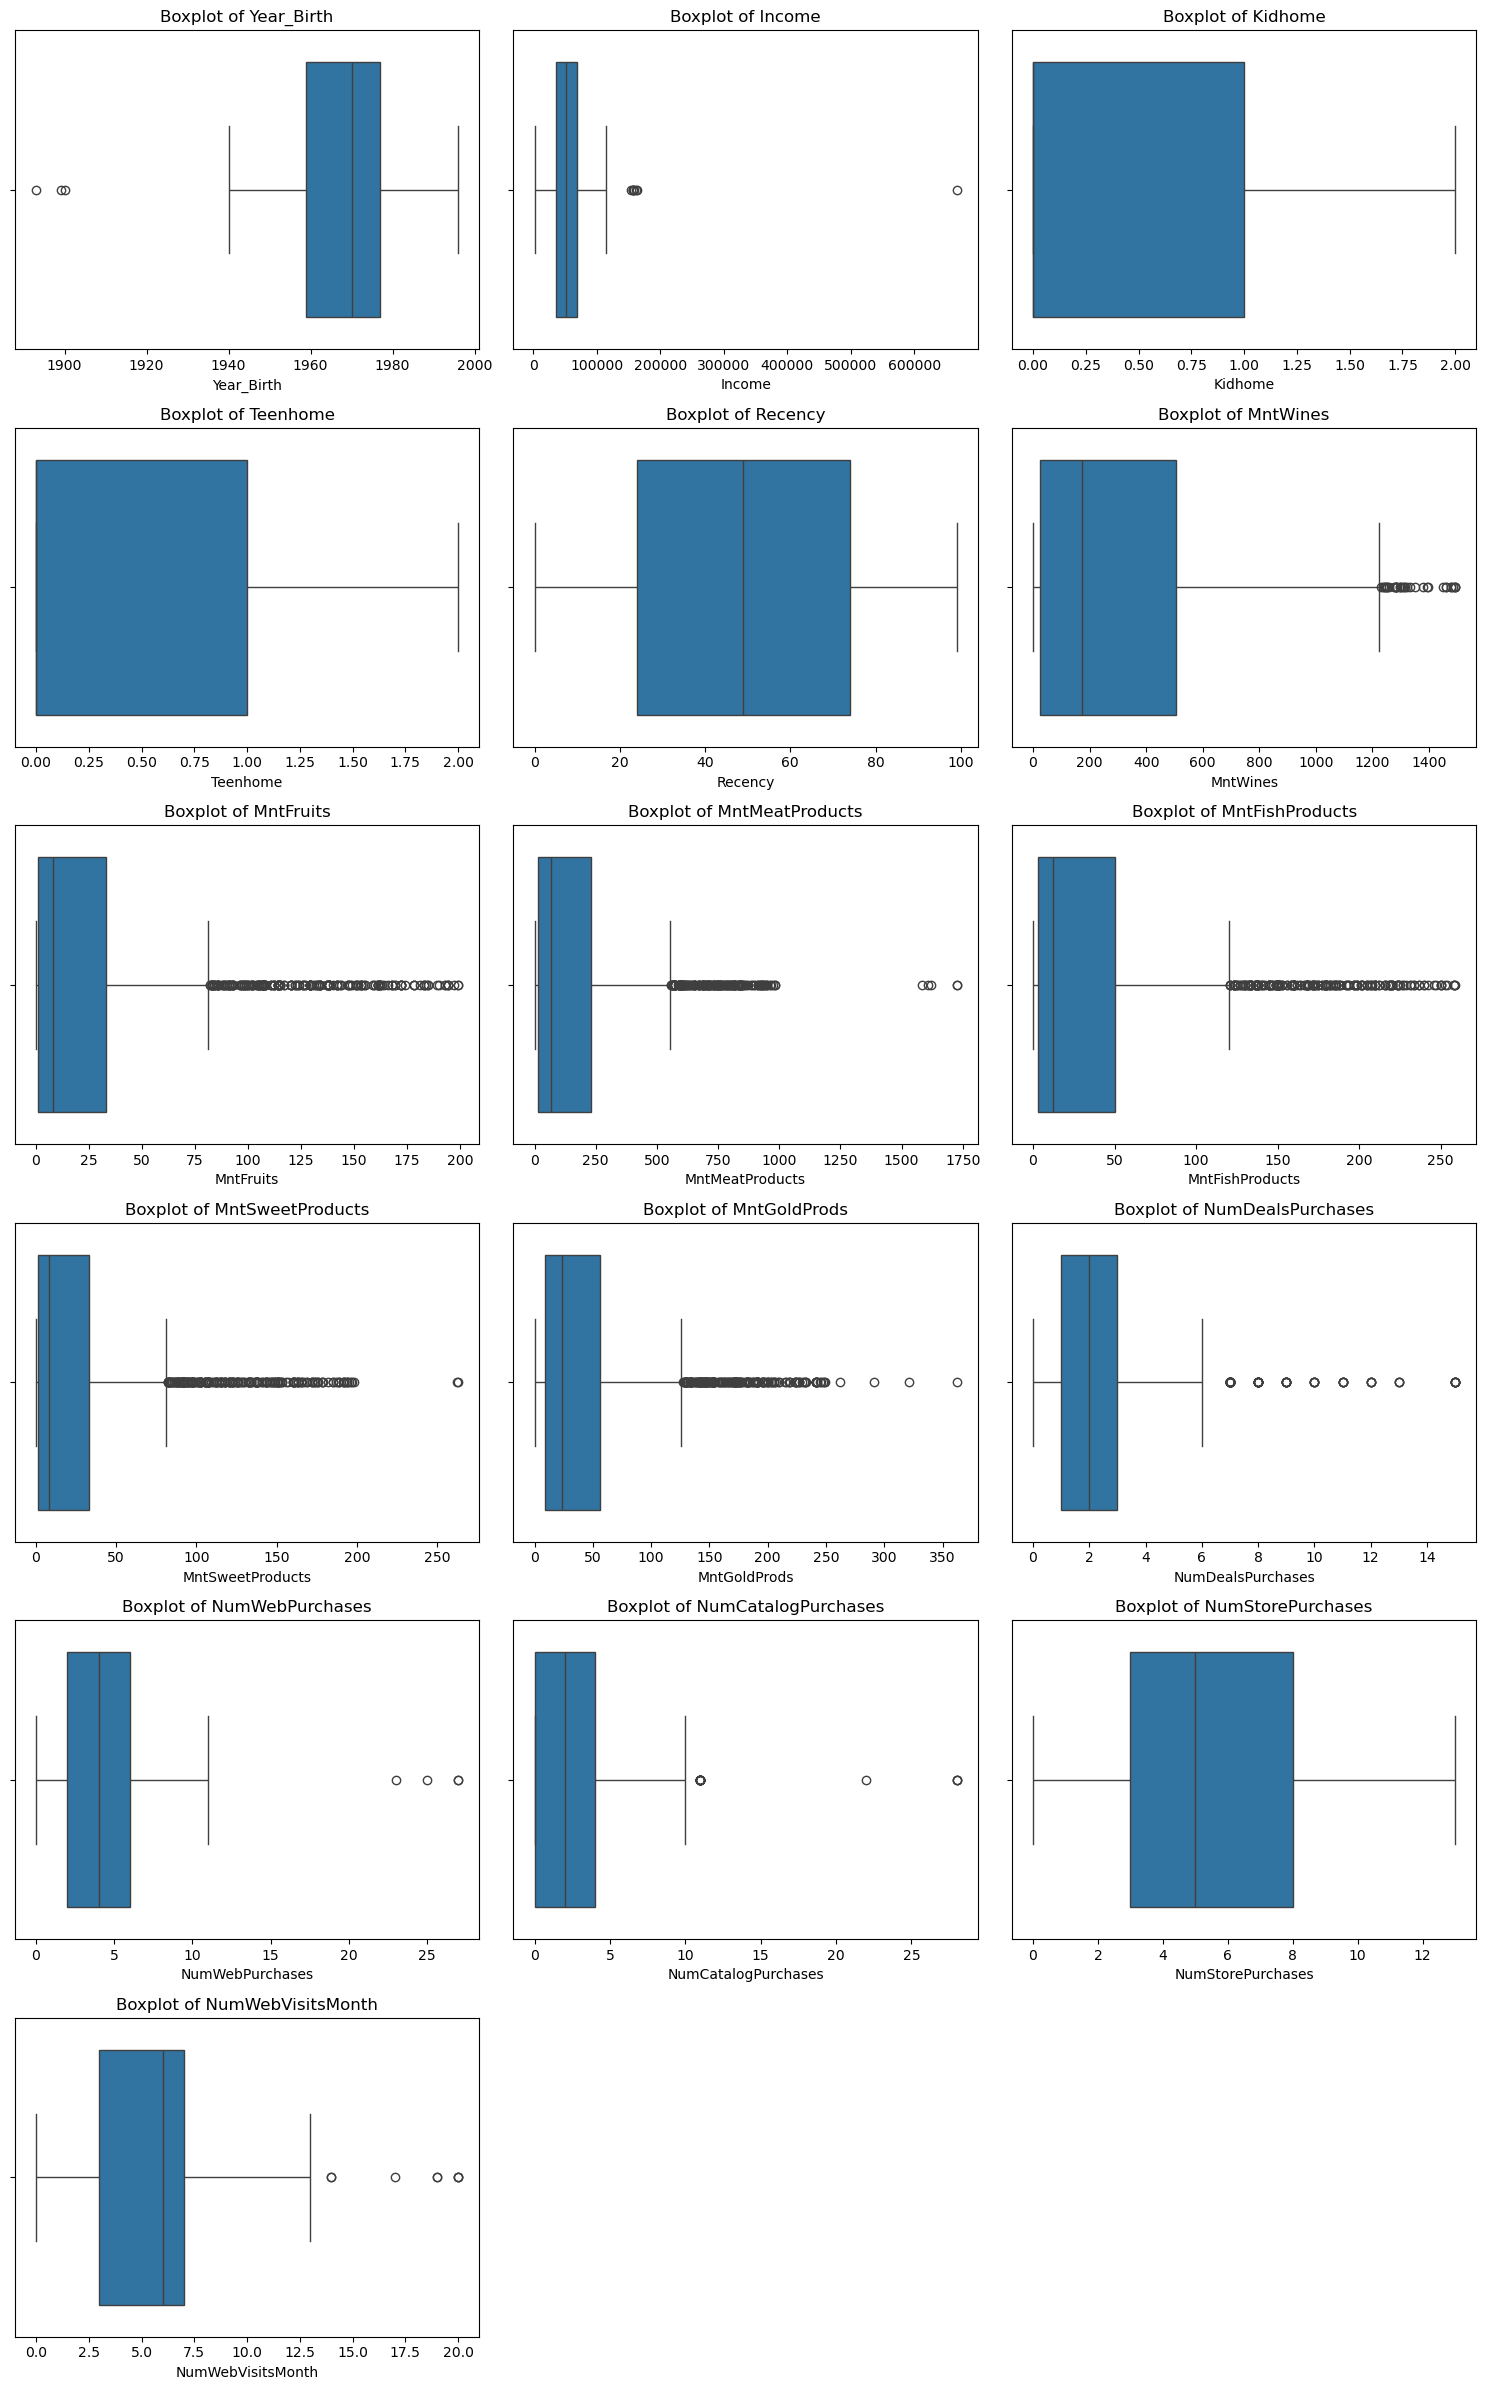

In [53]:
#visualize the outliers using boxplots
def plot_outliers(dataframe):
    n_cols = 3
    n_plots = len(numerical_cols)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=dataframe[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()


# Run the outlier visualization
plot_outliers(df)


## handling the outliers
# We will use the capping method to handle outliers. This involves replacing outliers with the nearest non-outlier value, which is determined by the IQR method.


In [54]:
# Capping method to handle outliers
def cap_outliers(dataframe):

    df_capped = dataframe.copy()

    for col in numerical_cols:
        # Calculate IQR
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before capping
        outliers_before = len(df_capped[(df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)])

        # Apply capping
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)

        # Count outliers after capping
        outliers_after = len(df_capped[(df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)])

        if outliers_before > 0:
            print(f"{col}: {outliers_before} outliers capped")

    print(f"\nOutlier capping completed!")
    return df_capped #return the capped DataFrame while preserving the original DataFrame

# Apply capping to the dataset
df_capped = cap_outliers(df)





Year_Birth: 3 outliers capped
Income: 8 outliers capped
MntWines: 35 outliers capped
MntFruits: 227 outliers capped
MntMeatProducts: 175 outliers capped
MntFishProducts: 223 outliers capped
MntSweetProducts: 248 outliers capped
MntGoldProds: 207 outliers capped
NumDealsPurchases: 86 outliers capped
NumWebPurchases: 4 outliers capped
NumCatalogPurchases: 23 outliers capped
NumWebVisitsMonth: 8 outliers capped

Outlier capping completed!


## Visualizatin after capping
# Visualize the capped data using boxplots
We will create boxplots for each numerical column to visualize the effect of capping on outliers. The boxplots will show the distribution of the data and highlight any remaining outliers after capping.

Boxplots of capped data only:


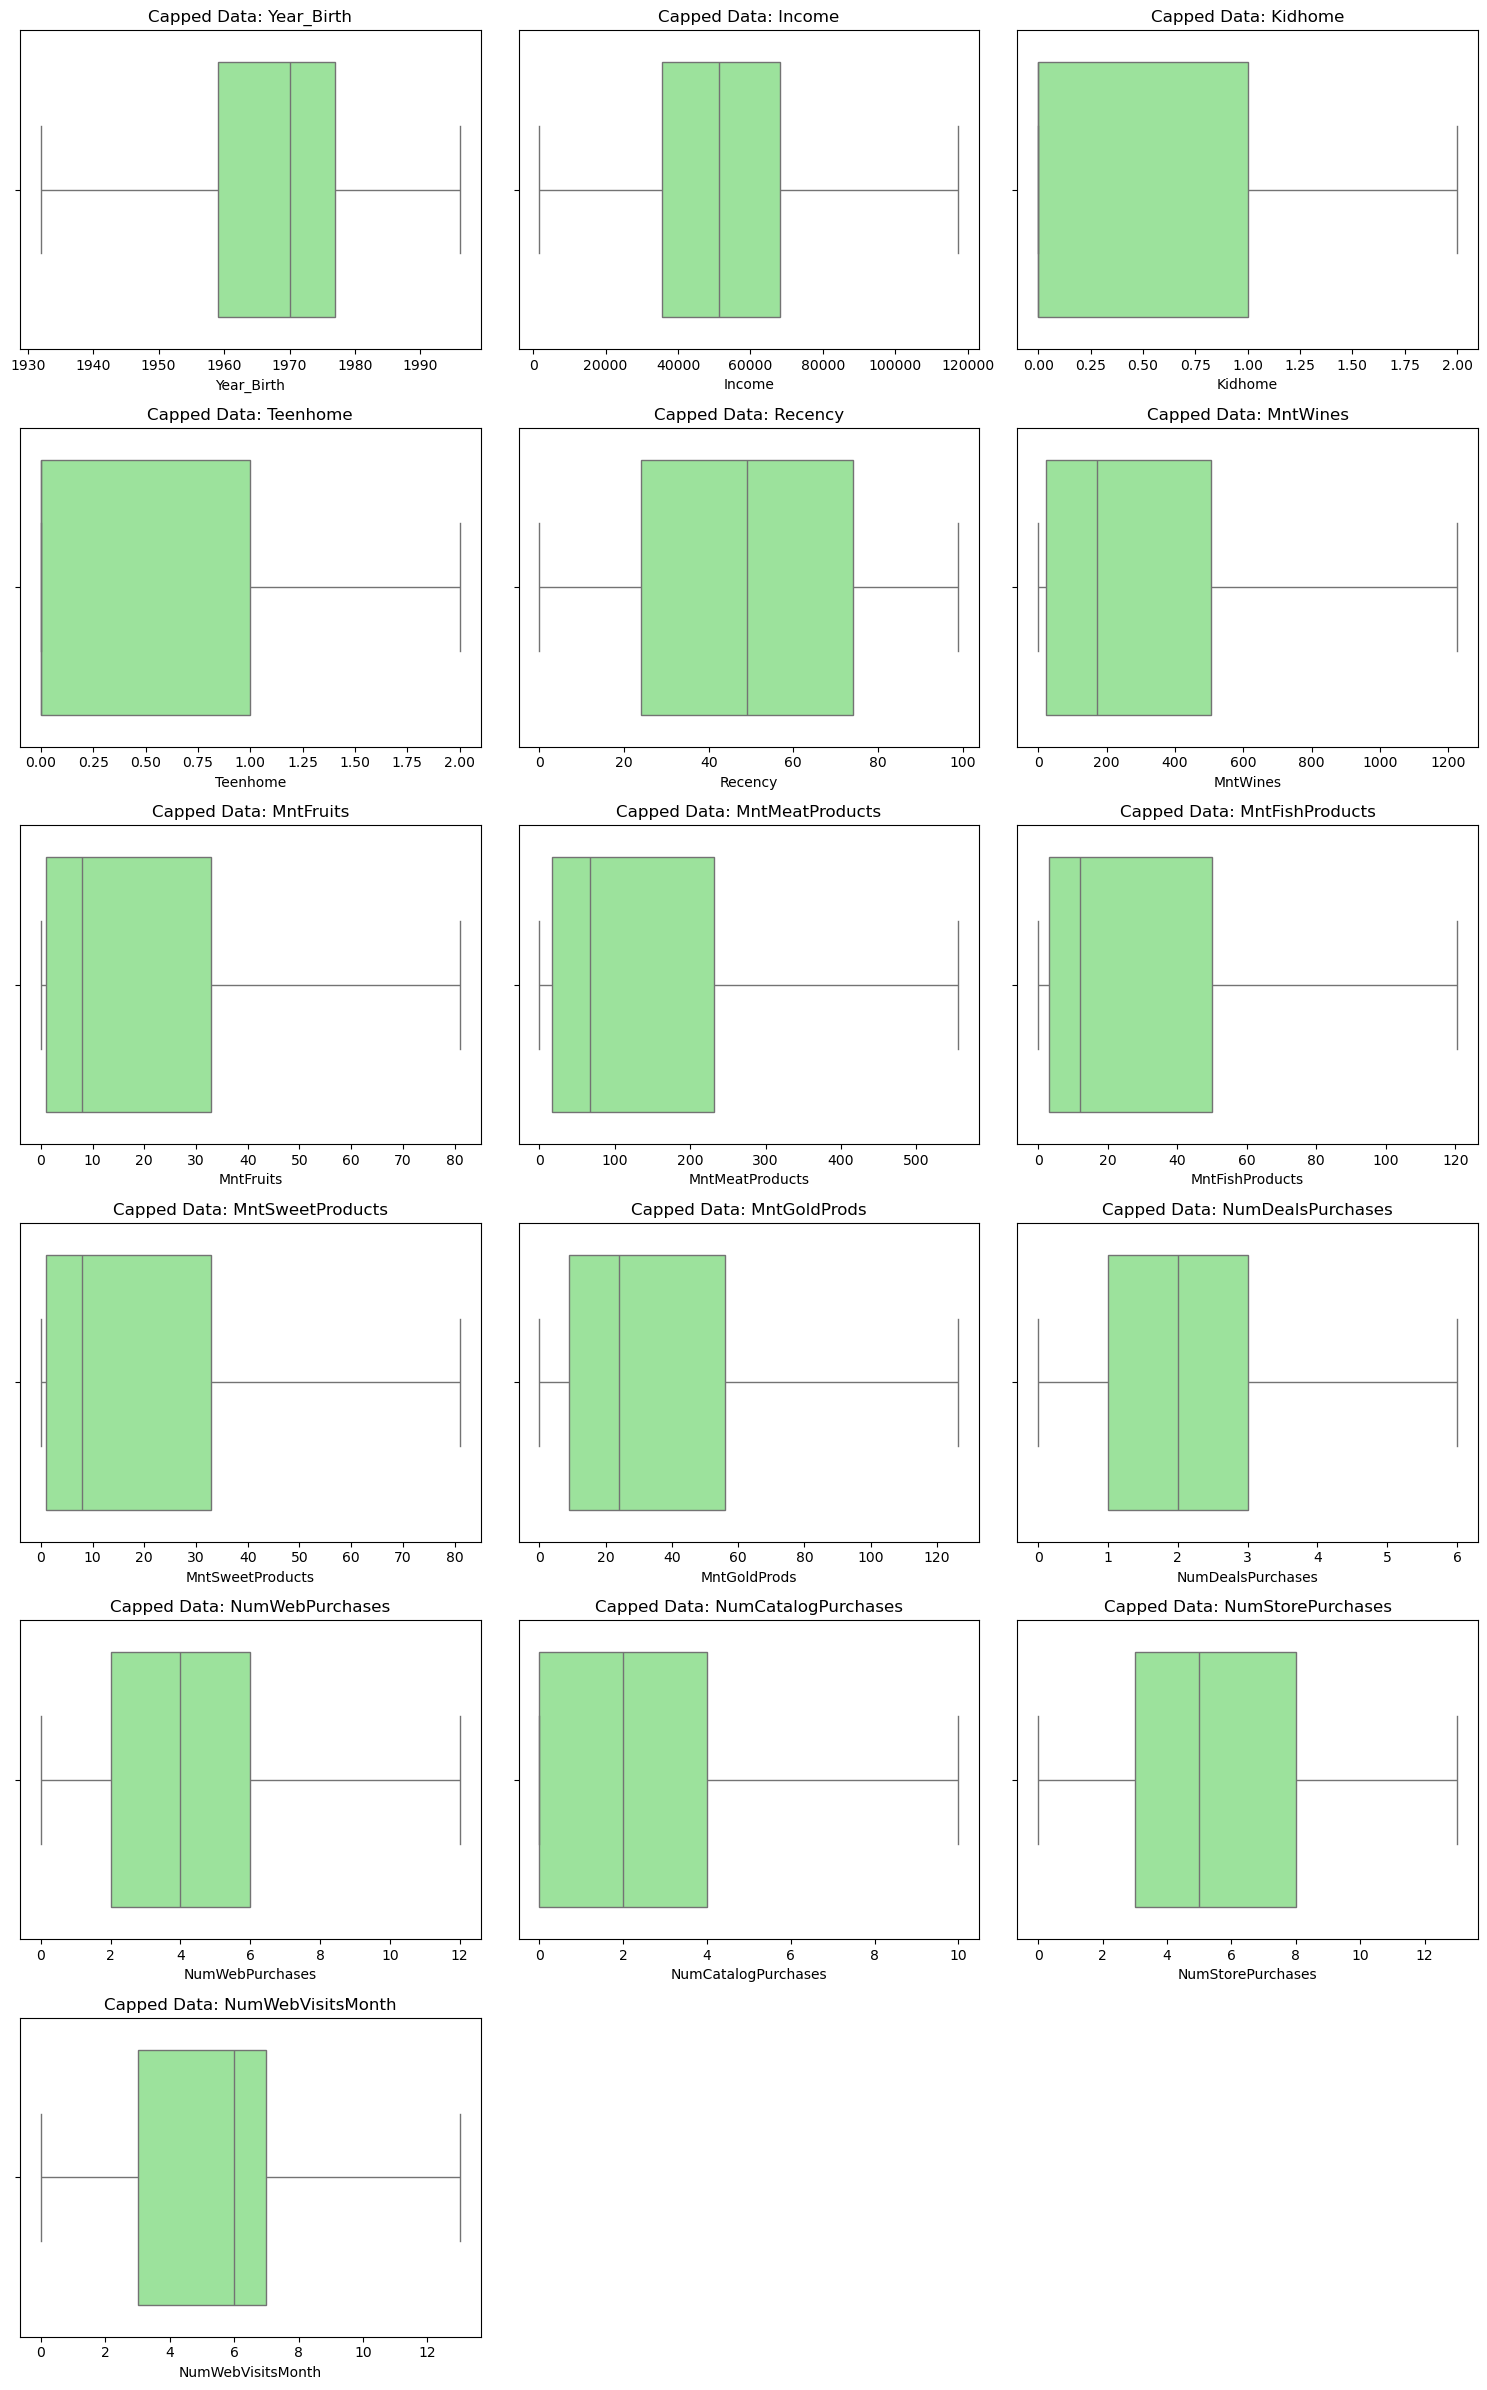

Existing cleaned_customer_segmentation.csv found, removing it...
File removed successfully.
New cleaned_customer_segmentation.csv saved successfully (216.94 KB)
Loaded cleaned dataset with shape: (2240, 27)


In [55]:


# Also created a simple boxplot of just the capped data
def plot_capped_data_only(capped_df):

    if 'ID' in numerical_cols:
        numerical_cols.remove('ID')

    n_cols = 3
    n_plots = len(numerical_cols)
    n_rows = (n_plots + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=capped_df[col], color='lightgreen')
        plt.title(f'Capped Data: {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

print("Boxplots of capped data only:")
plot_capped_data_only(df_capped)

# Check if the cleaned customer CSV exists
if os.path.exists('cleaned_customer_segmentation.csv'):
    print(f"Existing cleaned_customer_segmentation.csv found, removing it...")
    os.remove('cleaned_customer_segmentation.csv')
    print("File removed successfully.")

# Save the new cleaned dataset
df_capped.to_csv('cleaned_customer_segmentation.csv', index=False)
print(f"New cleaned_customer_segmentation.csv saved successfully ({os.path.getsize('cleaned_customer_segmentation.csv')/1024:.2f} KB)")

# Verify the file was saved correctly
if os.path.exists('cleaned_customer_segmentation.csv'):
    # Load the cleaned dataset to confirm it was saved properly
    df_cleaned = pd.read_csv('cleaned_customer_segmentation.csv')
    print(f"Loaded cleaned dataset with shape: {df_cleaned.shape}")

## Feature Egineering
Feature engineering is the process of using domain knowledge to extract features from raw data that make machine learning algorithms work. In this section, we will create new features based on the existing data in the dataset.

In [56]:
from sklearn.preprocessing import LabelEncoder
# Load data
df = pd.read_csv('cleaned_customer_segmentation.csv')


## Text encoding
### Education
- we chose ordinal encoding to put into perspective the increasing level of education
1. first we will find the unique eduaction levels

In [57]:


unique_eduaction_levels= df['Education'].unique()

print(unique_eduaction_levels)

['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


## next steps
2. supply ordinal encoder with oredered categories

`['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
`

3. fit the education column

In [58]:
from sklearn.preprocessing import OrdinalEncoder

ordered_education_categories = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
ordinal_encoder = OrdinalEncoder(categories=[ordered_education_categories])

education_encoded = ordinal_encoder.fit_transform(df[['Education']])

df['Education'] = education_encoded

In [59]:

print('Unique Marital Status:')
print(df['Marital_Status'].unique())
print('\nMarital Status value counts:')
print(df['Marital_Status'].value_counts())

Unique Marital Status:
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']

Marital Status value counts:
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


## Marital status evaluation

### Unique Marital Status:
`['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
`
### Marital Status value counts:
`Marital_Status,
Married     864,
Together    580,
Single      480,
Divorced    232,
Widow        77,
Alone         3,
Absurd        2`

## Deduction
### Wrong data
- Yolo alone and absurd are wrong data entries.
- Alone is the same as single and its values can be replaced with single
- Absurd and yolo will be replaced with the mode



In [60]:
# replace Alone with Single
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
print('\nMode: ',df['Marital_Status'].mode()[0])
# Absurd and yolo  replaced with the mode
df['Marital_Status'] = df['Marital_Status'].replace(['YOLO','Absurd'], df['Marital_Status'].mode()[0])

#now check for the current state
print('Unique Marital Status:')
print(df['Marital_Status'].unique())
print('\nMarital Status value counts:')
print(df['Marital_Status'].value_counts())



Mode:  Married
Unique Marital Status:
['Single' 'Together' 'Married' 'Divorced' 'Widow']

Marital Status value counts:
Marital_Status
Married     868
Together    580
Single      483
Divorced    232
Widow        77
Name: count, dtype: int64


### marital status encoding
We went with **one hot encoding**,
this is because ~~nominal encoding~~ would create a non existent _hierachy_

In [61]:
# One-hot encode marital status
marital_dummies = pd.get_dummies(df['Marital_Status'], prefix='Marital')
df = pd.concat([df.drop('Marital_Status', axis=1), marital_dummies], axis=1)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   float64
 3   Income               2240 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   float64
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   float64
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

In [62]:

# Feature engineering with corrected date parsing
try:

    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed', dayfirst=True)
except ValueError:

    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')


df['Age'] = 2025- df['Year_Birth']
df['Total_Dependents'] = df['Kidhome'] + df['Teenhome']
df['Is_Parent'] = (df['Total_Dependents'] > 0).astype(int)
df['Total_Spending'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
df['Total_Purchases'] = df[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
df['Average_Spent'] = df['Total_Spending']/df['Total_Purchases'].replace(0,1)
df['Tenure_Days'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days
df['TotalAcceptedCmp']=df[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']].sum(axis=1)
df['WebPurchaseRatio'] = df['NumWebPurchases'] / df['Total_Purchases'].replace(0, 1)
df['StorePurchaseRatio'] = df['NumStorePurchases'] / df['Total_Purchases'].replace(0, 1)

campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Total_Accepted_Campaigns'] = df[campaign_cols].sum(axis=1)
df['Ever_Accepted_Campaign'] = (df['Total_Accepted_Campaigns'] > 0).astype(int)

# Verify date conversion
print("\nDate conversion samples:")
print(df[['Dt_Customer', 'Tenure_Days']].head())

# Drop unnecessary columns
# df = df.drop(['ID', 'Year_Birth', 'Z_CostContact', 'Z_Revenue','Complain','Response','Kidhome', 'Teenhome','AcceptedCmp1','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds'], axis=1, errors='ignore')

# Check if the featured customer CSV exists
if os.path.exists('featured_customer_segmentation.csv'):
    print(f"Existing featured_customer_segmentation.csv found, removing it...")
    os.remove('featured_customer_segmentation.csv')
    print("File removed successfully.")

# Save the new featured dataset
df.to_csv('featured_customer_segmentation.csv', index=False)
print(f"New featured_customer_segmentation.csv saved successfully ({os.path.getsize('featured_customer_segmentation.csv')/1024:.2f} KB)")




Date conversion samples:
  Dt_Customer  Tenure_Days
0  2012-09-04         4697
1  2014-03-08         4147
2  2013-08-21         4346
3  2014-02-10         4173
4  2014-01-19         4195
Existing featured_customer_segmentation.csv found, removing it...


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'featured_customer_segmentation.csv'

In [ ]:
df=pd.read_csv('cleaned_customer_segmentation.csv')
print("\nFirst 10 rows with all columns:")
print(df.head(10))


First 10 rows with all columns:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   
5  7446        1967      Master       Together  62513.0        0         1   
6   965        1971  Graduation       Divorced  55635.0        0         1   
7  6177        1985         PhD        Married  33454.0        1         0   
8  4855        1974         PhD       Together  30351.0        1         0   
9  5899        1950         PhD       Together   5648.0        1         1   

  Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  NumStorePurchases  \
0  2012-09-04       58     

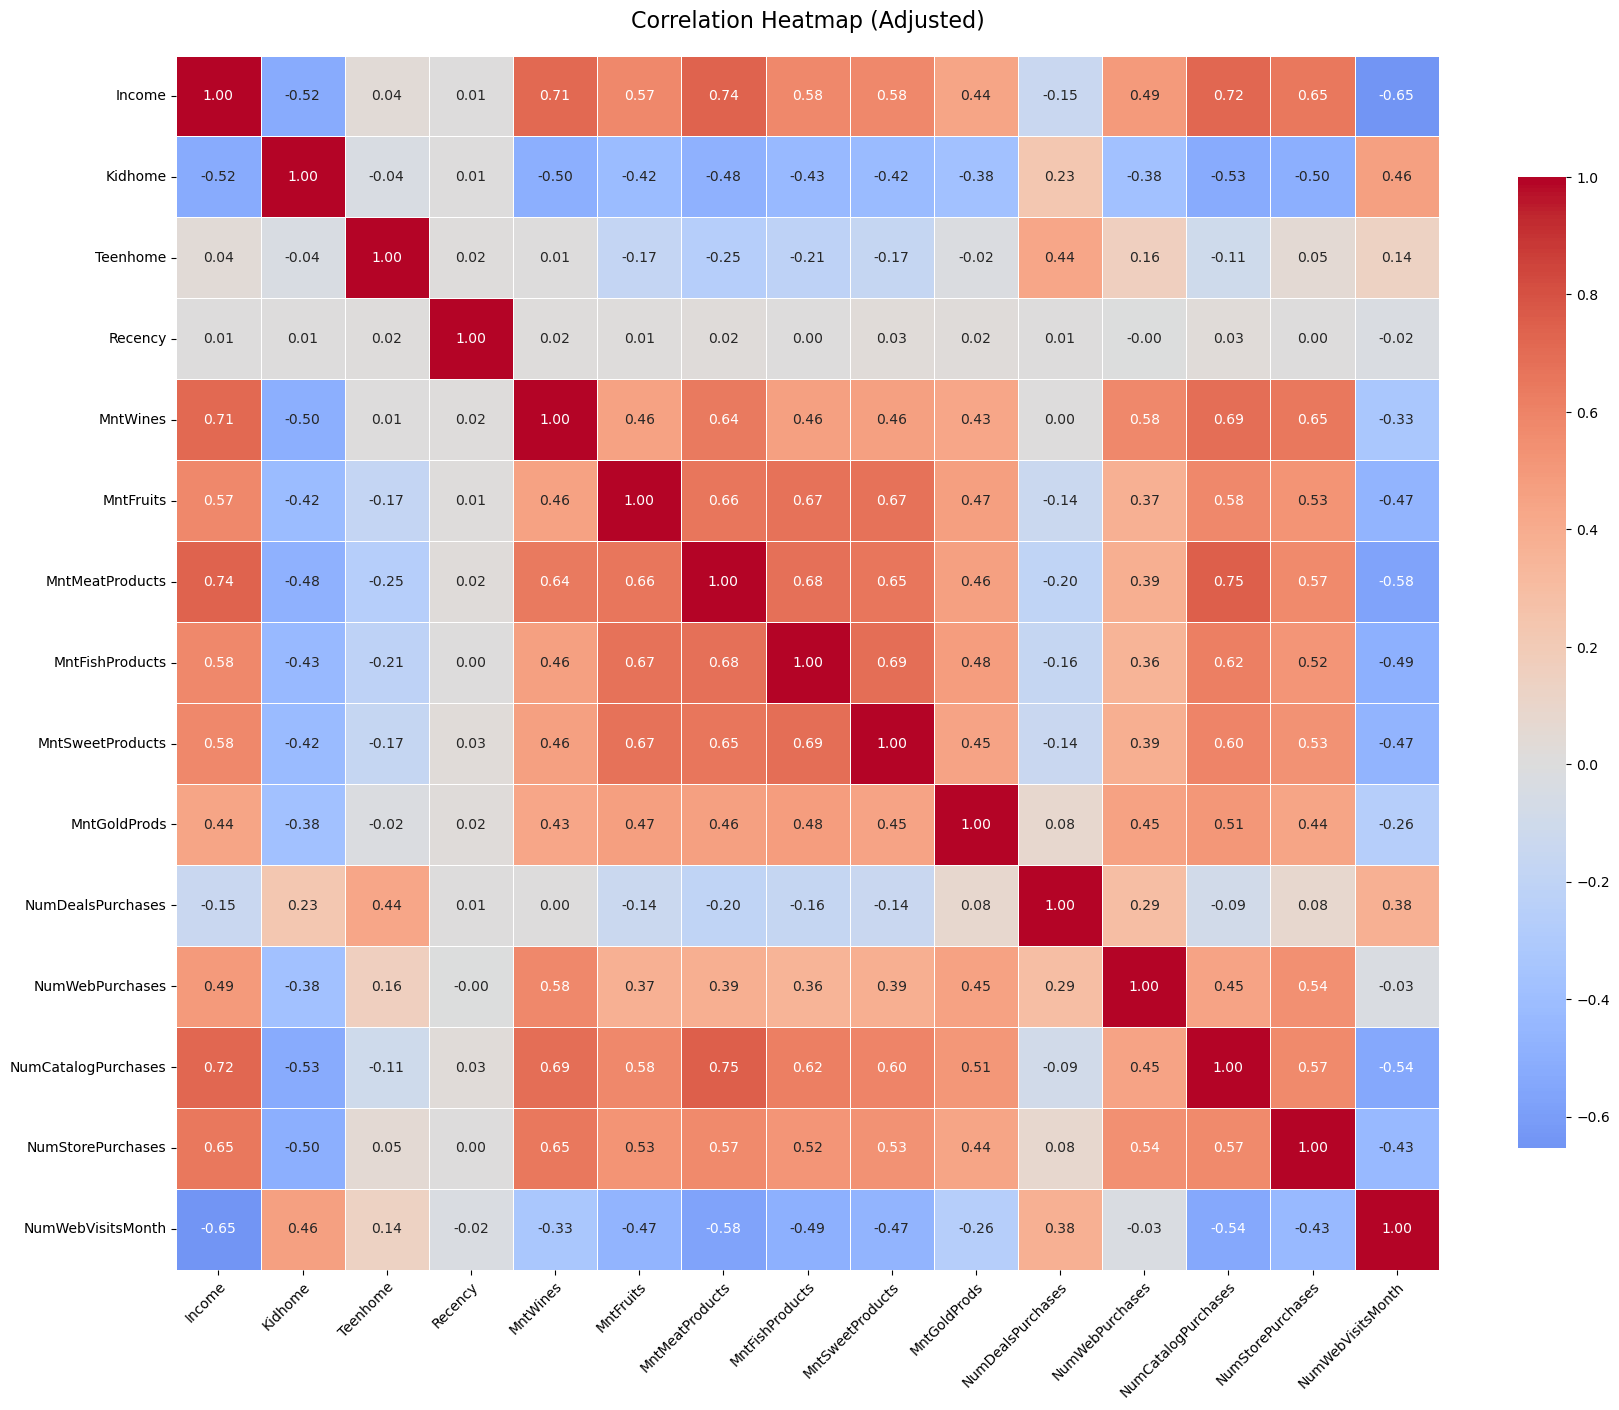

In [ ]:

# Select numerical columns (exclude IDs/constants)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
cols_to_drop = ['ID','Year_Birth','Dt_Customer','Complain','Response','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
numerical_cols = [col for col in numerical_cols if col not in cols_to_drop]

# Calculate correlations
corr_matrix = df[numerical_cols].corr()

# Set up the plot
plt.figure(figsize=(18, 14))  # Increased size for more columns

# Create heatmap with adjustments
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    annot_kws={'size': 10}  # Smaller annotation font
)

# Rotate and align labels
plt.xticks(
    rotation=45,
    ha='right',
    rotation_mode='anchor'
)
plt.yticks(rotation=0)

# Force tight layout and adjust margins
plt.tight_layout(pad=2.0)  # Extra padding
plt.title('Correlation Heatmap (Adjusted)', fontsize=16, pad=20)
plt.show()

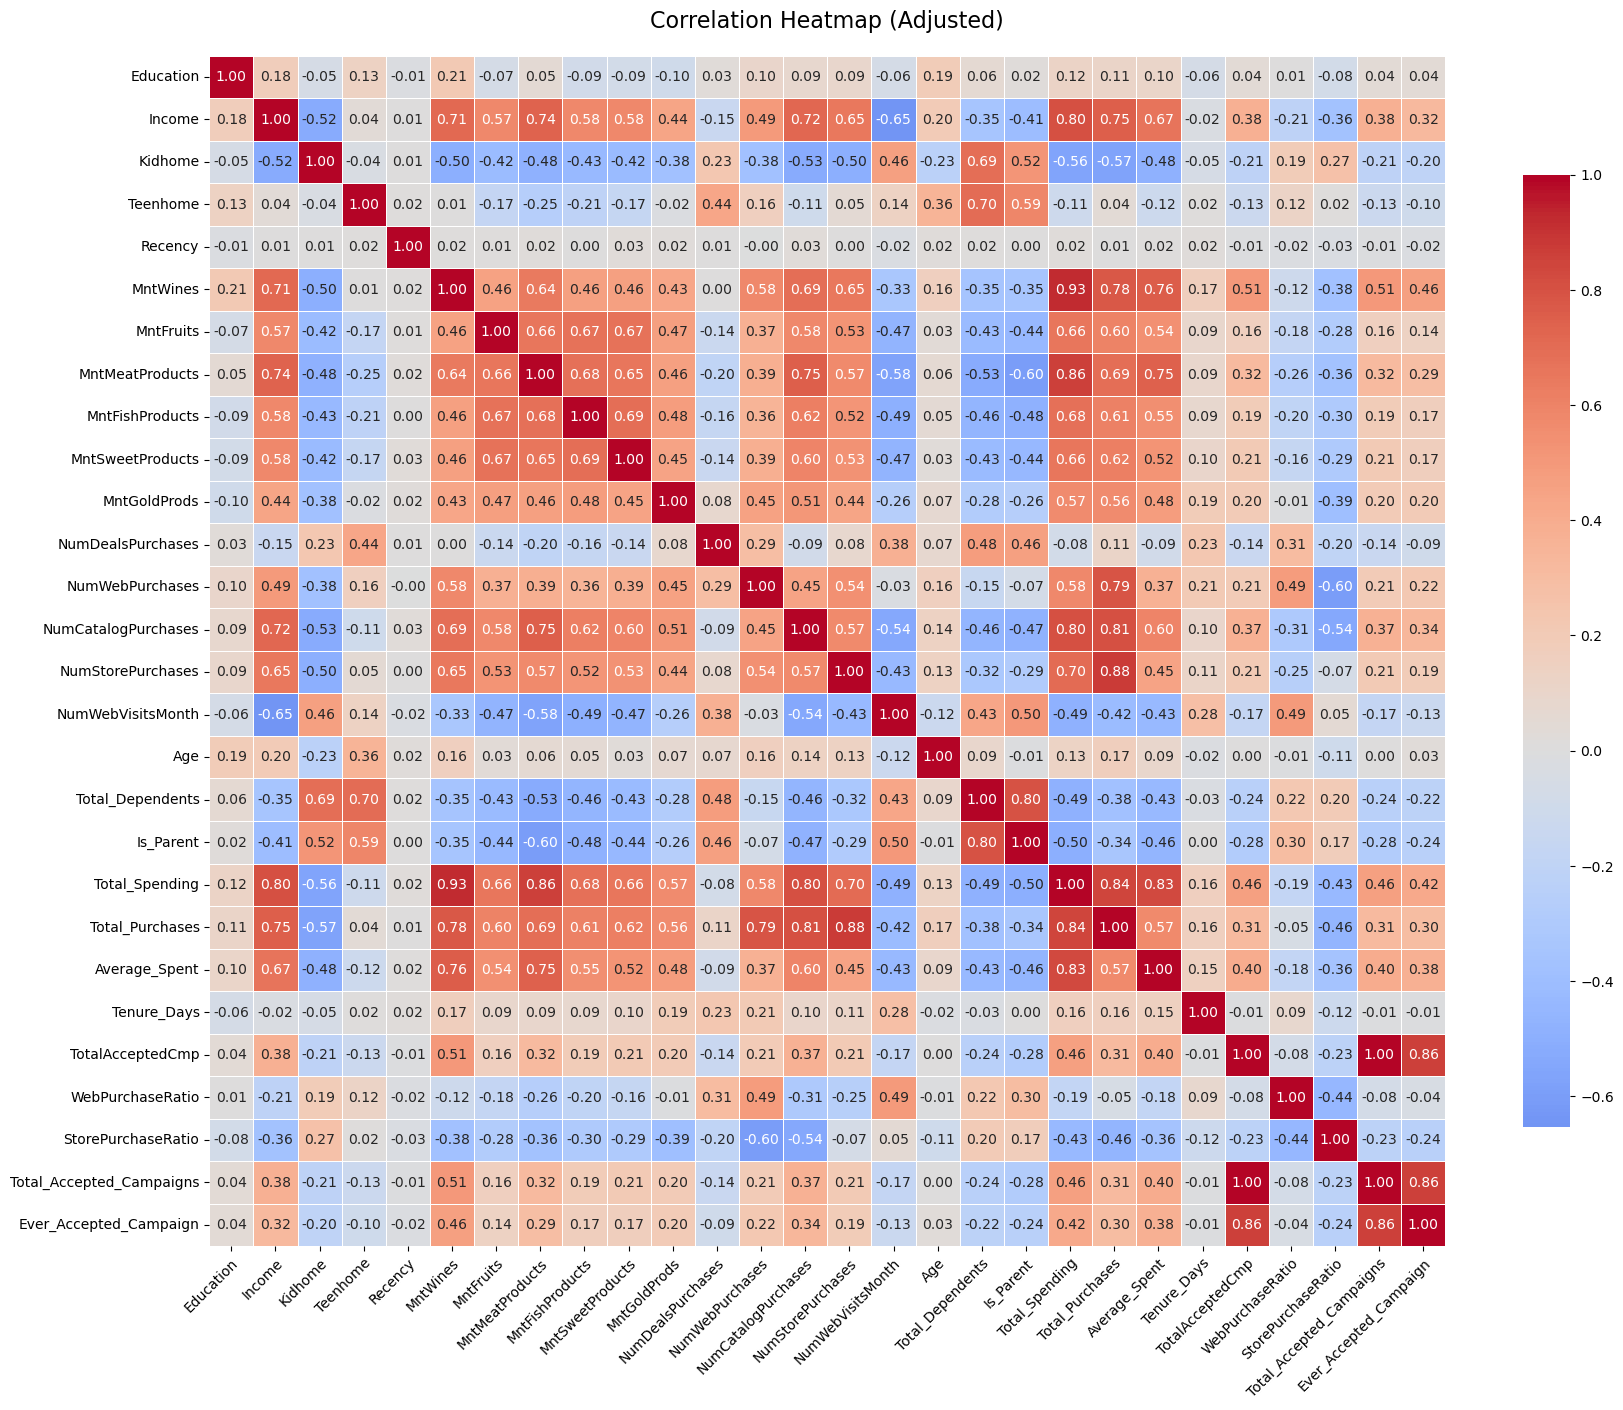

In [ ]:


#this is the heatmap for the featured csv

# Load data
df = pd.read_csv('featured_customer_segmentation.csv')

# Select numerical columns (exclude IDs/constants)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
cols_to_drop = ['ID','Year_Birth','Dt_Customer','Complain','Response','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']
numerical_cols = [col for col in numerical_cols if col not in cols_to_drop]

# Calculate correlations
corr_matrix = df[numerical_cols].corr()

# Set up the plot
plt.figure(figsize=(18, 14))  # Increased size for more columns

# Create heatmap with adjustments
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    annot_kws={'size': 10}  # Smaller annotation font
)

# Rotate and align labels
plt.xticks(
    rotation=45,
    ha='right',
    rotation_mode='anchor'
)
plt.yticks(rotation=0)

# Force tight layout and adjust margins
plt.tight_layout(pad=2.0)  # Extra padding
plt.title('Correlation Heatmap (Adjusted)', fontsize=16, pad=20)
plt.show()

In [ ]:
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Marital_Divorced', 'Marital_Married',
       'Marital_Single', 'Marital_Together', 'Marital_Widow', 'Age',
       'Total_Dependents', 'Is_Parent', 'Total_Spending', 'Total_Purchases',
       'Average_Spent', 'Tenure_Days', 'TotalAcceptedCmp', 'WebPurchaseRatio',
       'StorePurchaseRatio', 'Total_Accepted_Campaigns',
       'Ever_Accepted_Campaign'],
      dtype='object')


# Clustering based on Spending Patterns
In this section, we will perform clustering on the dataset to identify distinct customer segments based on their spending patterns. We will use KMeans clustering for this purpose.

1. **Feature Selection**: We will select relevant features that represent customer spending patterns.

In [ ]:
spending_features = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','Total_Spending'
]



2. **Data Preparation**: We will standardize the selected features to ensure that they are on the same scale.

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv('featured_customer_segmentation.csv')

# Select relevant spending columns
X = df[spending_features]

# extract ratios for all the spending features
# Create ratio features for spending categories, excluding the Total_Spending itself
spending_categories = [feature for feature in spending_features if feature != 'Total_Spending']
for feature in spending_categories:
    X[f'{feature}_ratio'] = X[feature] / X['Total_Spending'].replace(0, 1)  # Avoid division by zero

df_ratios= X[[f'{feature}_ratio' for feature in spending_categories]]


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ratios)

print(df_ratios.head())



   MntWines_ratio  MntFruits_ratio  MntMeatProducts_ratio  \
0        0.409281         0.052208               0.351917   
1        0.407407         0.037037               0.222222   
2        0.548969         0.063144               0.163660   
3        0.207547         0.075472               0.377358   
4        0.409953         0.101896               0.279621   

   MntFishProducts_ratio  MntSweetProducts_ratio  MntGoldProds_ratio  
0               0.077667                0.052208            0.056719  
1               0.074074                0.037037            0.222222  
2               0.143041                0.027062            0.054124  
3               0.188679                0.056604            0.094340  
4               0.109005                0.063981            0.035545  


3. Optimizing the **number of clusters** using the Elbow Method

[13439.999999999998, 9338.521568291337, 7260.948676197479, 6534.595335988886, 6013.296957549026, 5308.496669362053, 4895.082396434316, 4625.696509868743, 4362.80518808102]


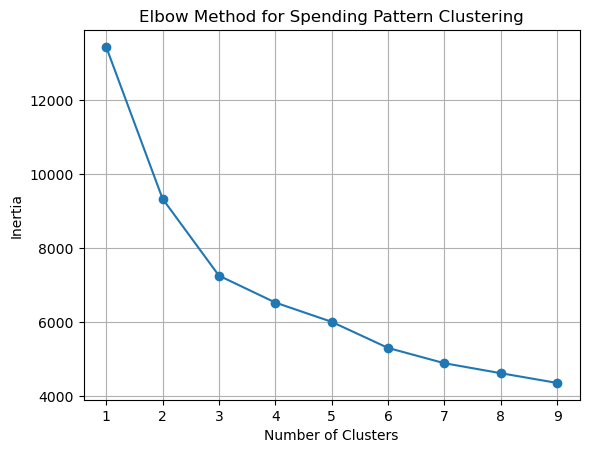

In [ ]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

print(inertia)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Spending Pattern Clustering')
plt.grid(True)
plt.show()


4. **Applying KMeans Clustering** with the optimal number of clusters
We will choose 3 clusters based on the elbow method.
this is because the inertia starts to level off after 3 clusters, indicating that adding more clusters does not significantly reduce inertia.

In [ ]:
# Apply KMeans clustering with clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Spending_Cluster'] = kmeans.fit_predict(X_scaled)


cluster_summary = df.groupby('Spending_Cluster')[spending_features].mean().round(2)
print(cluster_summary)


                  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Spending_Cluster                                                          
0                   434.40      14.41           104.97            20.49   
1                   296.84      31.46           248.48            48.11   
2                    30.94      15.28            29.94            21.08   

                  MntSweetProducts  MntGoldProds  Total_Spending  
Spending_Cluster                                                  
0                            14.51         39.69          628.46  
1                            32.18         44.15          701.23  
2                            14.83         28.59          140.65  


5. **Analyzing Cluster Characteristics**

We will analyze the characteristics of each cluster by computing the mean spending for each product category.

We will also visualize the average spending per product category for each cluster using a grouped bar chart.


                    MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Spending_Cluster                                                            
0                 434.395506  14.408989       104.965169        20.485955   
1                 296.843683  31.455032       248.481799        48.113490   
2                  30.935096  15.283654        29.939904        21.079327   

                  MntSweetProducts  MntGoldProds  Total_Spending  
Spending_Cluster                                                  
0                        14.514607     39.685393      628.455618  
1                        32.178801     44.153640      701.226445  
2                        14.826923     28.588942      140.653846  


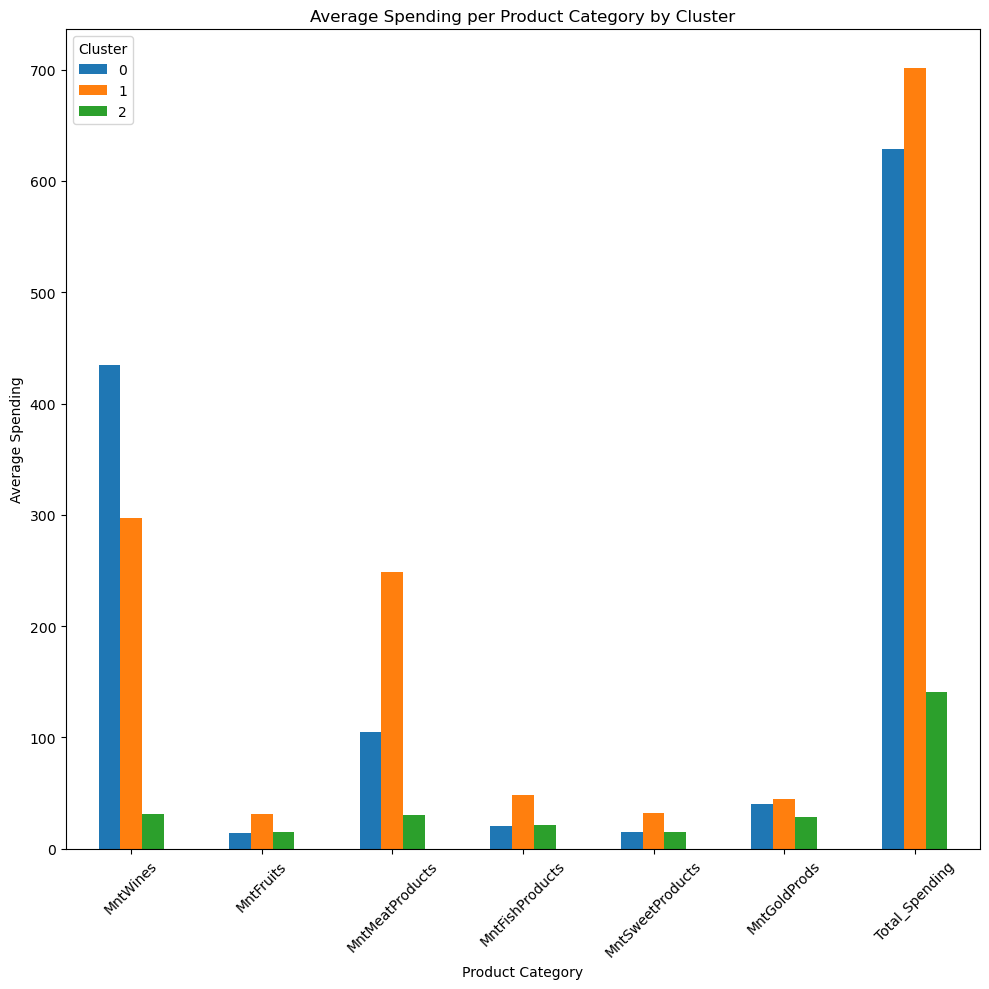

In [ ]:
# Group by cluster and compute means
cluster_means = df.groupby('Spending_Cluster')[spending_features].mean()

print(cluster_means)

# Transpose for easier plotting (products on x-axis)
cluster_means_T = cluster_means.T

# Plot grouped bar chart
cluster_means_T.plot(kind='bar', figsize=(10, 10))

plt.title('Average Spending per Product Category by Cluster')
plt.xlabel('Product Category')
plt.ylabel('Average Spending')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here is the grouped bar chart showing the average spending per product category for each cluster. Each bar represents the average spending for a specific product category, and different colors represent different clusters. This visualization helps us understand how each cluster allocates its spending across various product categories.

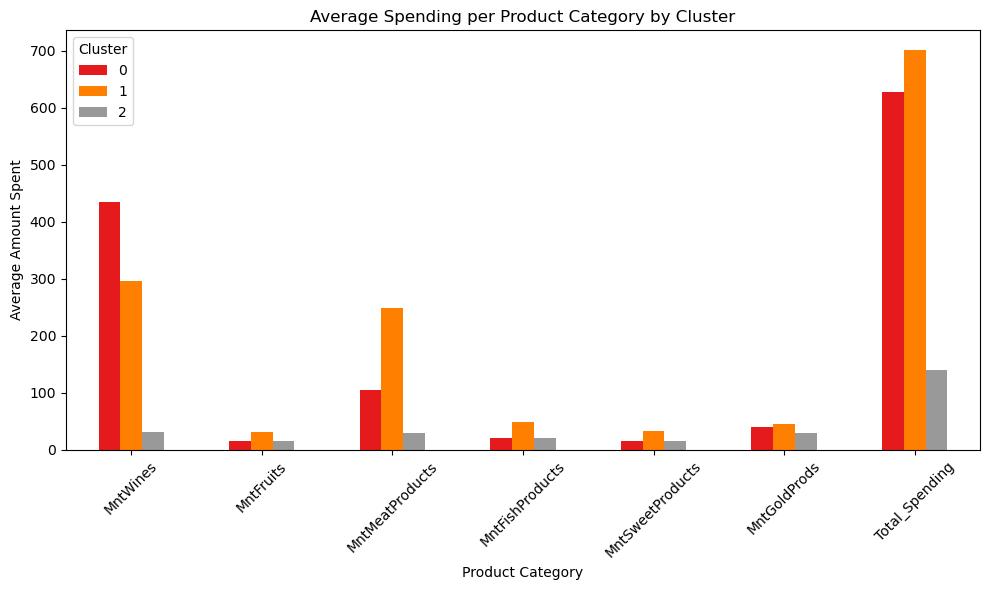

In [ ]:
# Transpose the DataFrame so categories are on the x-axis
cluster_means.T.plot(kind='bar', figsize=(10, 6), colormap='Set1')

plt.title('Average Spending per Product Category by Cluster')
plt.ylabel('Average Amount Spent')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


This is a stacked bar chart showing the average spending per product category for each cluster. Each segment of the bar represents the average spending for a specific product category, and different colors represent different clusters. This visualization helps us understand how each cluster allocates its spending across various product categories.

                  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Spending_Cluster                                                          
0                    69.12       2.29            16.70             3.26   
1                    42.33       4.49            35.44             6.86   
2                    21.99      10.87            21.29            14.99   

                  MntSweetProducts  MntGoldProds  
Spending_Cluster                                  
0                             2.31          6.31  
1                             4.59          6.30  
2                            10.54         20.33  


<Figure size 1200x800 with 0 Axes>

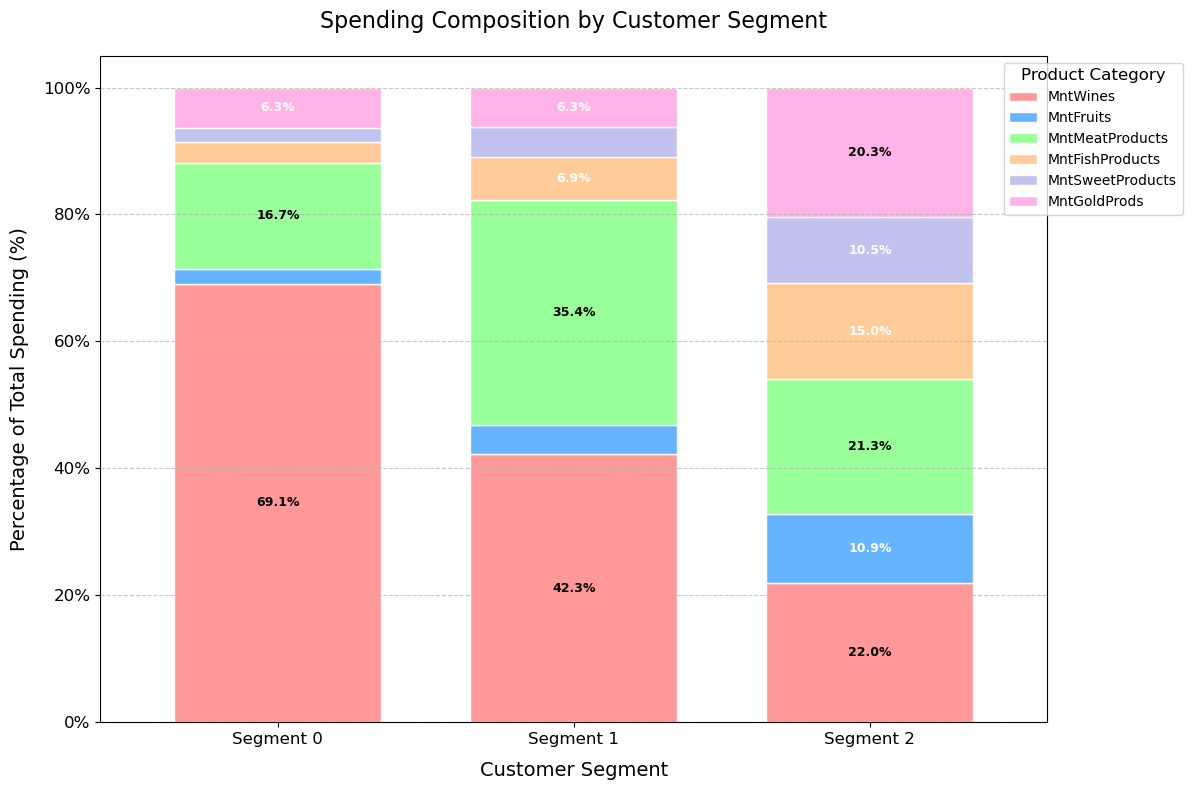

In [ ]:
# Normalize category spending by total spending per cluster
normalized = df.groupby('Spending_Cluster')[
    ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
     'MntSweetProducts', 'MntGoldProds']
].mean()

# Add total spending per cluster
normalized['Total'] = normalized.sum(axis=1)

# Divide each category by total to get proportions
normalized_pct = normalized.div(normalized['Total'], axis=0).drop(columns='Total')

# Optional: Multiply by 100 for percentage
normalized_pct *= 100

print(normalized_pct.round(2))

# plot the normalized dta
# Create a colorful stacked bar chart with improved styling
plt.figure(figsize=(12, 8))

# Use a colorful palette
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']
normalized_pct.plot(
    kind='bar',
    stacked=True,  # Use stacked bars to show composition
    figsize=(12, 8),
    color=colors,
    width=0.7,  # Slightly thinner bars
    edgecolor='white'  # White edge for contrast between segments
)

# Enhance styling
plt.title('Spending Composition by Customer Segment', fontsize=16, pad=20)
plt.xlabel('Customer Segment', fontsize=14, labelpad=10)
plt.ylabel('Percentage of Total Spending (%)', fontsize=14, labelpad=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage signs to y-axis
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in current_values])

# Improve legend
plt.legend(
    title='Product Category',
    title_fontsize=12,
    fontsize=10,
    loc='upper right',
    bbox_to_anchor=(1.15, 1)
)

# Add value labels on the stacked bars
for i, cluster in enumerate(normalized_pct.index):
    cumulative = 0
    for j, col in enumerate(normalized_pct.columns):
        value = normalized_pct.loc[cluster, col]
        if value > 5:  # Only show labels for segments > 5%
            plt.text(
                i,
                cumulative + value / 2,  # Center of segment
                f"{value:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                color='black' if value > 15 else 'white'  # Better contrast
            )
        cumulative += value

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rename x-axis labels to more meaningful names
plt.gca().set_xticklabels([
    'Segment 0',
    'Segment 1',
    'Segment 2'
])

plt.tight_layout()
plt.show()


In [65]:
df = pd.read_csv('featured_customer_segmentation.csv') 
print("Columns in cleaned dataset:")
print(df.columns.tolist())
cluster_features = [
    'Total_Spending',
    'Income',
    'Recency',
    'Age',
    'Total_Dependents',
    'WebPurchaseRatio',
    'NumStorePurchases',
    'MntWines',
    'MntMeatProducts'
]

Columns in cleaned dataset:
['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Marital_Widow', 'Age', 'Total_Dependents', 'Is_Parent', 'Total_Spending', 'Total_Purchases', 'Average_Spent', 'Tenure_Days', 'TotalAcceptedCmp', 'WebPurchaseRatio', 'StorePurchaseRatio', 'Total_Accepted_Campaigns', 'Ever_Accepted_Campaign']


In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

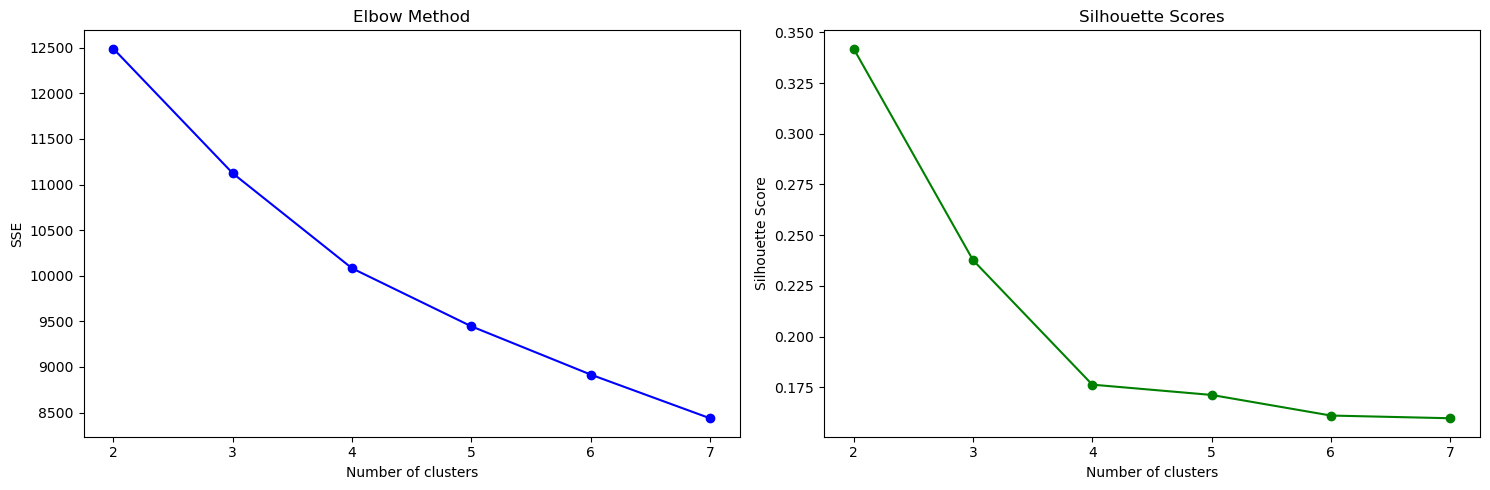

In [68]:
from sklearn.cluster import KMeans          
from sklearn.metrics import silhouette_score

sse = []
sil_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    
    # Always calculate silhouette for k>1
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# 4. Visualization (Elbow + Silhouette) - FIXED
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, 'go-')  # Use same k_range for both
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [69]:

optimal_k =2
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Segment'] = final_kmeans.fit_predict(X_scaled)

# Save clustered data
df.to_csv('segmented_customers.csv', index=False)

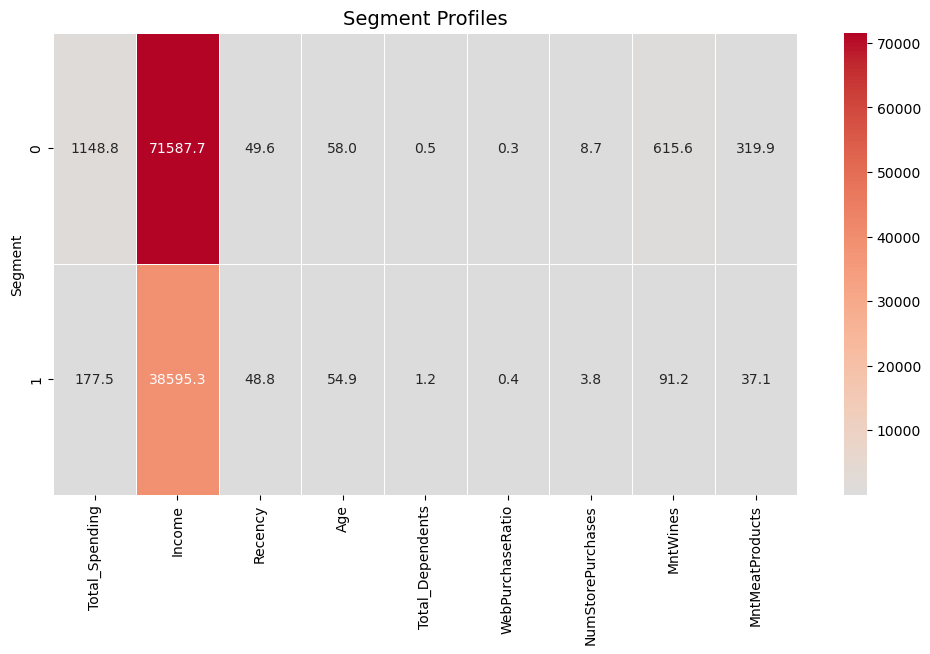

In [70]:
# Get cluster centers in original scale
cluster_centers = scaler.inverse_transform(final_kmeans.cluster_centers_)
segment_profiles = pd.DataFrame(cluster_centers, columns=cluster_features)
segment_profiles['Segment'] = segment_profiles.index

# Visualize segment characteristics
plt.figure(figsize=(12, 6))
sns.heatmap(
    segment_profiles.set_index('Segment'),
    annot=True, 
    cmap='coolwarm',
    fmt='.1f',
    linewidths=.5,
    center=0
)
plt.title('Segment Profiles', fontsize=14)
plt.savefig('segment_profiles.png', bbox_inches='tight')
plt.show()

In [71]:
# For education - find most common in each segment
# If education is encoded numerically, map back to labels
education_map = {
    0: 'Basic',
    1: '2n Cycle',
    2: 'Graduation',
    3: 'Master',
    4: 'PhD'
}

# If marital status is one-hot encoded
marital_statuses = [col for col in df.columns if 'Marital_' in col]

segment_summary = df.groupby('Segment').agg({
    'Income': 'mean',
    'Age': 'mean',
    'Total_Dependents': 'mean',
    'Is_Parent': 'mean',
    'Education': lambda x: education_map[x.mode()[0]] if 'Education' in df else 'N/A',
    **{status: 'mean' for status in marital_statuses}  # Include all marital status columns
}).reset_index()

# Format output
pd.set_option('display.float_format', '{:.1f}'.format)
print("\nSegment Demographic Summary:")
print(segment_summary)

# Save to file
segment_summary.to_csv('segment_demographics.csv', index=False)


Segment Demographic Summary:
   Segment  Income  Age  Total_Dependents  Is_Parent   Education  \
0        0 71587.7 58.0               0.5        0.5  Graduation   
1        1 38595.3 54.9               1.2        0.9  Graduation   

   Marital_Divorced  Marital_Married  Marital_Single  Marital_Together  \
0               0.1              0.4             0.2               0.3   
1               0.1              0.4             0.2               0.3   

   Marital_Widow  
0            0.0  
1            0.0  


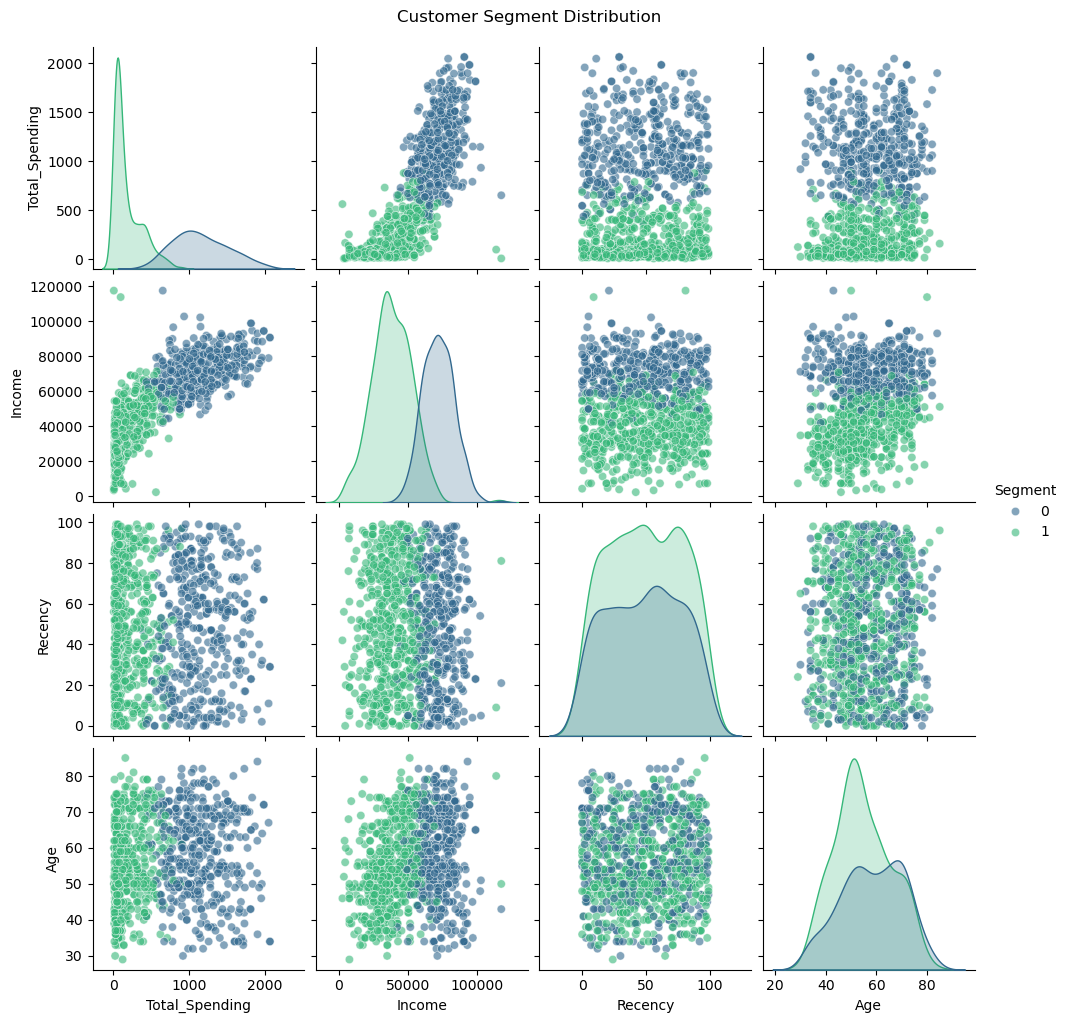

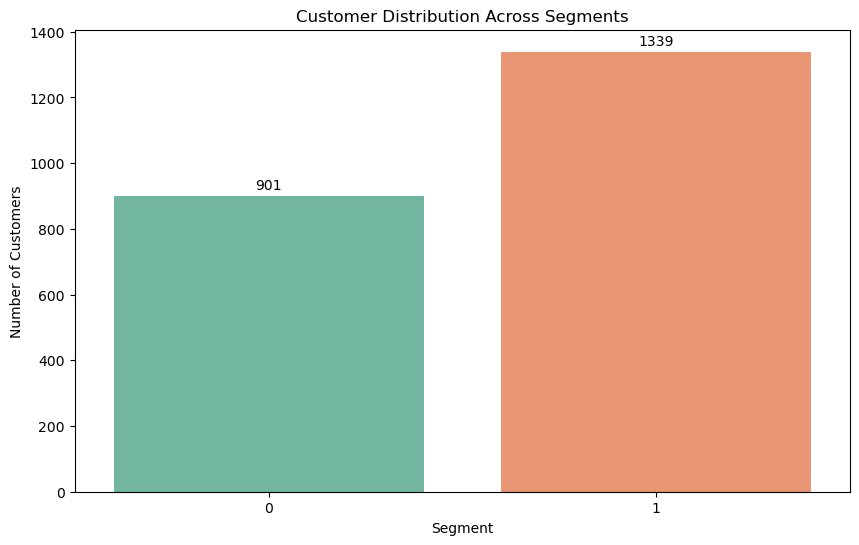

In [ ]:
# Pairplot for key features
sns.pairplot(
    data=df.sample(1000),  # Sample for performance
    vars=['Total_Spending', 'Income', 'Recency', 'Age'],
    hue='Segment',
    palette='viridis',
    plot_kws={'alpha': 0.6}
)
plt.suptitle('Customer Segment Distribution', y=1.02)
plt.savefig('segment_distribution.png', bbox_inches='tight')
plt.show()

# Segment size visualization
segment_counts = df['Segment'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Set2')
plt.title('Customer Distribution Across Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
for i, count in enumerate(segment_counts):
    plt.text(i, count + 20, str(count), ha='center')
plt.savefig('segment_sizes.png', bbox_inches='tight')
plt.show()